In [29]:
import mesa
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import requests
import os
import pickle

from mesa import Agent, Model
from mesa.time import RandomActivation # random order of agent actions
from mesa.space import MultiGrid # multiple agents er cell
from mesa.datacollection import DataCollector

In [ ]:
url_for_carers = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=is_carer"
url_format= "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=ctry,E92000001&dimensions=health_in_general,highest_qualification"
url_for_area_types = "https://api.beta.ons.gov.uk/v1/population-types/UR/area-types"
url_for_observations = "https://api.beta.ons.gov.uk/v1/population-types/UR/dimensions"

unpaid_care_file = 'unpaid_care_data.pkl'
url_for_carers = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=is_carer"

url_general_health = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=health_in_general"
general_health_file = "general_health.pkl"

url_disability = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=disability"
disability_file = "disability.pkl"

headers = {'User-Agent': 'InternshipExerciseSC/1.0'}

def get_ons_data(url_to_fetch):
    response = requests.get(url_to_fetch, headers=headers) 

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        print(f"Data Request successful")
    else:
        print(f"Failed to retrieve data: {response.status_code}")

    return data

def pickle_data(file_path, url):
    if os.path.exists(file_path):
        # Load the data from the file 
        with open(file_path, 'rb') as file:
            data_to_pickle = pickle.load(file)
        print("Data loaded from file") 
    else:
        # Fetch the data from the API 
        data_to_pickle = get_ons_data(url) 
        # Save the data to a file 
        with open(file_path, 'wb') as file:
            pickle.dump(data_to_pickle, file)
        print("Data fetched from API and saved to file")

    return data_to_pickle

def clear_pickled_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} has been deleted.")
    else:
        print(f"{file_path} does not exist.")

def process_ons_data(pulled_ons_data):
    processed_data = []
    for item in pulled_ons_data['observations']:
        dimension_data = {}
        for dim in item['dimensions']:
            #turning values into keys and then values into values... Sort-of makes sense...
            dimension_data[dim['dimension']] = dim['option']
        dimension_data['observation'] = item['observation']
        processed_data.append(dimension_data)
    processed_ons_data = pd.DataFrame(processed_data).drop(columns=('2023 Upper tier local authorities'))
    return processed_ons_data

# clear_pickled_file(unpaid_care_file)
# clear_pickled_file(general_health_file)

raw_unpaid_care_data = pickle_data(unpaid_care_file, url_for_carers)
raw_general_health_data = pickle_data(general_health_file, url_general_health)

unpaid_care_data = process_ons_data(raw_unpaid_care_data)
general_health_data = process_ons_data(raw_general_health_data)

raw_disability_data = pickle_data(disability_file, url_disability)
disability_data = process_ons_data(raw_disability_data)
                                  
#this'll be needed for distribution above all else.
#maybe include Does not Apply in provides no unpaid care?
provides_care_df = unpaid_care_data.drop(axis=0, index=[0])\
.reset_index(drop=True)

#Constants
TOTAL_OBSERVATIONS = unpaid_care_data['observation'].sum()
N_DOES_PROVIDE_CARE = provides_care_df['observation'].sum()
N_DOES_NOT_PROVIDE_CARE = unpaid_care_data['observation'].loc[1].sum()

# Creating care distribution
provides_care_df['p_care_band'] = provides_care_df['observation'] / TOTAL_OBSERVATIONS
provides_care_df_sorted = provides_care_df['p_care_band'].sort_values(ascending=True)

provides_care_df
#~agents would do something similar to this to decide if a resident agent is an unpaid carer
def provides_care(n):
    care_capacity_list = []
    for _ in range(n):
        if random.random() < 0.5:
            care_capacity = round(random.uniform(20, 34),1)
            care_capacity_list.append(care_capacity)
        else:
            care_capacity = 0
            care_capacity_list.append(0)

#Getting there, this'll just be some idle data filling now...
#Additionally, deciding whether a resident agent is a carer is also quite close to this...

    return care_capacity_list

provides_care_df.plot()


In [30]:
#ABS: Model

'''
To-Do:
**as model matures, should micro-providers get added? - SEE: adding in unpaid carers ... 

**consider what the model is measuring - Started

*eventually, should all model parameters be dervied from a number of resident agents
  which itself should be derived from a size of population figure?

- decide on capacity of care_giving agents - TO-DO

- decide if density of agents is something you want to pursue
'''

# initialising agent which will act as a resident
class Resident_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        self.received_care = False
        self.initiate_care_needs()
    
    def initiate_care_needs(self):
        self.generate_care_needs = round(random.uniform(5,10),1)
        self.care_needs = self.generate_care_needs
        # print(f"resident {self.unique_id} has {self.care_needs} care needs")

    def receive_care(self, care_delivered):
            if self.care_needs > 0:
                self.care_needs = round(self.care_needs - care_delivered, 1)
                # print(f'resident {self.unique_id} received {care_delivered} hours of care this week')
                       
# initialisng unpaid carer agent
class UnpaidCare_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity
        # print(f"unpaid carer {self.unique_id} has {self.care_capacity} care capacity")

    def give_care(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 0:
            for inhabitant in cellmates:
                if isinstance(inhabitant, Resident_Agent) and inhabitant.care_needs > 0 and self.care_capacity > 0:
                    # Calculate care to be delivered without exceeding care capacity
                    care_needed = min(self.care_capacity, inhabitant.care_needs)
                    care_delivered = min(care_needed, self.care_capacity)
                    # print(f"unpaid carer {self.unique_id} gave {care_delivered} hours of care")
                    self.care_capacity = max(0, round(self.care_capacity - care_delivered, 1))
                    inhabitant.receive_care(care_delivered)
                    # print(f"inhabitant now has {inhabitant.care_needs} hours of care remaining")
                    if inhabitant.care_needs <= 0:
                        return False

    def step(self):
        if self.give_care():
            while self.care_capacity > 0:
                self.give_care()

# initialising micro provider agent
class MicroProvider_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center= True)

        new_position = random.choice(possible_steps)
        
        self.model.grid.move_agent(self, new_position)
            
    def give_care(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            for inhabitant in cellmates:
                if isinstance(inhabitant, Resident_Agent) and self.care_capacity > 0:
                    care_needed = min(self.care_capacity, inhabitant.care_needs)
                    care_delivered = min(care_needed, self.care_capacity)
                    # print(f"Micro=Provider Agent {self.unique_id} gave {care_delivered} hours of care to resident {inhabitant.unique_id}")
                    self.care_capacity = max(0, round(self.care_capacity - care_delivered, 1))
                    inhabitant.receive_care(care_delivered)
                    if inhabitant.care_needs <= 0:
                        return False

   # step method - this determines what actions are taken per step                 
    def step(self):
            self.move()
            if self.give_care():
                while self.care_capacity > 0:
                    self.give_care()
            else:
                pass

# initialising homecare agent
class Homecare_Agent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity
        # print(f"Homecare_Agent {self.unique_id} has {self.generate_care_capacity} hours of care capacity")

    def set_target_positions(self, target_positions):
        self.target_positions = list(target_positions)
        random.shuffle(self.target_positions)

    def move(self):
        target_position = None
        for pos in self.target_positions:
            cellmates = self.model.grid.get_cell_list_contents(pos)
            for inhabitant in cellmates:
                if isinstance (inhabitant, Resident_Agent):
                    target_position = pos
                    break
                        
        if target_position != None:
            self.model.grid.move_agent(self, target_position)
            self.target_positions.remove(target_position)
        else:
            pass

    def give_care(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for inhabitant in cellmates:
                if isinstance(inhabitant, Resident_Agent) and self.care_capacity > 0:
                    care_needed = min(self.care_capacity, inhabitant.care_needs)
                    care_delivered = min(care_needed, self.care_capacity)
                    # print(f"Homecare Agent {self.unique_id} gave {care_delivered} hours of care to resident {inhabitant.unique_id}")
                    self.care_capacity = max(0, round(self.care_capacity - care_delivered, 1))
                    inhabitant.receive_care(care_delivered)
                    # print(f"inhabitant now has {inhabitant.care_needs} hours of care remaining")

    def step(self):
        self.move()
        if self.give_care():
            while self.care_capacity > 0:
                    self.give_care()

class Care_Model(Model):
    # constructor
    def __init__(self,
                N_RESIDENT_AGENTS,
                N_MICROPROVIDER_AGENTS,
                N_HOMECARE_AGENTS,
                N_UNPAIDCARE_AGENTS,
                width,
                height
                ):
        super().__init__()

        # models own variables
        self.num_resident_agents = N_RESIDENT_AGENTS
        self.num_microprovider_agents = N_MICROPROVIDER_AGENTS
        self.num_homecare_agents = N_HOMECARE_AGENTS
        self.num_unpaidcare_agents = N_UNPAIDCARE_AGENTS
        self.running = True
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
    
        # adding resident agents
        for i in range(self.num_resident_agents):
            a = Resident_Agent(i, self)
            self.schedule.add(a)
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
            # print(f'placed resident agent {a.pos}')

        # adding unpaid care agents
        # for i in range(self.num_unpaidcare_agents):
        #     a = UnpaidCare_Agent(i, self)
        #     self.schedule.add(a)
        #     possible_start_cells = ([(agent.pos) for agent in self.schedule.agents
        #                               if isinstance(agent, Resident_Agent)])
        #     random.shuffle(possible_start_cells)
        #     start_cell = possible_start_cells.pop()

        #     try:
        #         self.grid.place_agent(a, start_cell)

        #     except:
        #         x = random.randrange(self.grid.width)
        #         y = random.randrange(self.grid.height)
        #         self.grid.place_agent(a, (x,y))

        # adding micro-provider agents
        for i in range(self.num_microprovider_agents):
            a = MicroProvider_Agent(i, self)
            self.schedule.add(a)
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))

        # adding homecare agents
        for i in range(self.num_homecare_agents):
            a = Homecare_Agent(i, self)
            self.schedule.add(a)
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
        
        # adding datacollector to model
        self.datacollector = DataCollector(
        model_reporters={
            "total_care_capacity": self.sum_total_capacity,
            "total_care_need": self.sum_total_care_need,
            "total_unpaid_care_given": self.unpaid_care_given,
            "total_home_care_given": self.home_care_given,
            "total_micro_care_given": self.micro_care_given
        }
        )

    # measures
    def sum_total_care_need(self):
        total_care_needs = []
        for agent in self.schedule.agents:
            if isinstance(agent, Resident_Agent):
                total_care_needs.append(agent.generate_care_needs)
        total_care_need_sum = sum(total_care_needs)
        return total_care_need_sum

    def sum_total_capacity(self):
        total_care_capacity = []
        for agent in self.schedule.agents:
            if not isinstance(agent, Resident_Agent):
                total_care_capacity.append(agent.generate_care_capacity)
        total_care_capacity_sum = sum(total_care_capacity)
        return total_care_capacity_sum

    def unpaid_care_given(self):
        unpaid_care_given = []
        for agent in self.schedule.agents:
            if isinstance(agent, UnpaidCare_Agent):
                unpaid_care_given.append(agent.generate_care_capacity - agent.care_capacity)
            else:
                pass
        total_unpaid_care_given = sum(unpaid_care_given)
        return total_unpaid_care_given

    def micro_care_given(self):
        micro_care_given = []
        for agent in self.schedule.agents:
            if isinstance(agent, MicroProvider_Agent):
                micro_care_given.append(agent.generate_care_capacity - agent.care_capacity)
            else:
                pass
        total_micro_care_given = sum(micro_care_given)
        return total_micro_care_given
    
    def home_care_given(self):
        home_care_given = []
        for agent in self.schedule.agents:
            if isinstance(agent, Homecare_Agent):
                home_care_given.append(agent.generate_care_capacity - agent.care_capacity)
            else:
                pass
        total_home_care_given = sum(home_care_given)
        return total_home_care_given
    
    # what happens in each step of the model
    def step(self):

        # fisrt, collect data 
        self.datacollector.collect(self)
        
        # what happens in each step for each type of Agent
        for agent in self.schedule.agents:
            # homecare_agents
            if isinstance(agent, Homecare_Agent):
                # deciding where homecare agent can move to
                target_positions = ([(agent.pos) for agent in self.schedule.agents
                              if isinstance(agent, Resident_Agent)])
                random.shuffle(target_positions)
                agent.set_target_positions(target_positions)
                #resetting care capacity
                agent.care_capacity = agent.generate_care_capacity
                # print (f'homecare agent {agent.unique_id} care capacity is now {agent.care_capacity})
    
            # micro-provider agents
            if isinstance(agent, MicroProvider_Agent):
                agent.care_capacity = agent.generate_care_capacity
                # print(f' micro-provider agent {agent.unique_id} care capacity is now{agent.care_capacity}')

            # unpaid agents        
            if isinstance(agent, UnpaidCare_Agent):
                agent.care_capacity = agent.generate_care_capacity
                # print(f'unpaid care agent {agent.unique_id} care capacity is {agent.care_capacity}')

            if isinstance(agent, Resident_Agent):
                agent.care_needs = agent.generate_care_needs
                # print(f'resident agent {agent.unique_id} care needs is {agent.care_needs}')
            
            # after configuring unique behaviours, each agent steps
            agent.step()
        
        # adding more resident agents as time goes on
        if self.schedule.steps % 4 == 0:
            #resident agents are plcaed randomly
            for i in range(self.num_resident_agents, self.num_resident_agents + 1):
                a = Resident_Agent(i, self)
                self.schedule.add(a)
                try:
                    start_cell = self.grid.find_empty()
                    self.grid.place_agent(a, start_cell)
                except:
                    x = random.randrange(self.grid.width)
                    y = random.randrange(self.grid.height)
                    self.grid.place_agent(a, (x,y))
                # print(f"resident agent {a.unique_id} placed")

            self.num_resident_agents += 1

        # adding more unpaid care agents as time goes on
        target_unpaidcare_agents = round(self.num_resident_agents * 0.09)
        if target_unpaidcare_agents > self.num_unpaidcare_agents:
            for i in range(self.num_unpaidcare_agents, target_unpaidcare_agents):
                a = UnpaidCare_Agent(i, self)
                self.schedule.add(a)
                possible_start_cells = [agent.pos for agent in self.schedule.agents
                                        if isinstance(agent, Resident_Agent)]
                random.shuffle(possible_start_cells)
                start_cell = possible_start_cells.pop()
                try:
                    self.grid.place_agent(a, start_cell)
                except:
                    x = random.randrange(self.grid.width)
                    y = random.randrange(self.grid.height)
                    self.grid.place_agent(a, (x, y))
                # Update the number of unpaid care agents
                self.num_unpaidcare_agents += 1
                # print(f'placed unpaidcarer agent at {a.pos}')
        else:
            pass


        # add next step to schedule        
        self.schedule.step()

#Set the parameters for your model
N_RESIDENT_AGENTS = 40
N_MICROPROVIDER_AGENTS = 10
N_HOMECARE_AGENTS = 5
N_UNPAIDCARE_AGENTS = 0
width = 10
height = 10

model = Care_Model(
    N_RESIDENT_AGENTS,
    N_MICROPROVIDER_AGENTS,
    N_HOMECARE_AGENTS,
    N_UNPAIDCARE_AGENTS,
    width, 
    height)

# Run the model for a certain number of steps
num_steps = 50
for i in range(num_steps):
    # print(f"step {i}")
    model.step()

# To collect and visualize data, you can use the DataCollector you've set up
data = model.datacollector.get_model_vars_dataframe()
print(data)


    total_care_capacity  total_care_need  total_unpaid_care_given  \
0                 114.6            301.1                      0.0   
1                 147.7            306.2                     18.0   
2                 147.7            306.2                     24.3   
3                 147.7            306.2                     22.6   
4                 147.7            306.2                     17.8   
5                 147.7            311.8                     19.1   
6                 147.7            311.8                     24.3   
7                 147.7            311.8                     18.4   
8                 147.7            311.8                     24.3   
9                 147.7            317.1                     24.3   
10                147.7            317.1                     24.3   
11                147.7            317.1                     24.3   
12                147.7            317.1                     24.3   
13                147.7           

In [ ]:
data
data_area_plot = data.drop(columns = ['total_care_capacity', 'total_care_need'])


fig,ax = plt.subplots()
ax.set_ylim(ymin=0, ymax=data['total_care_need'].max()+10)
data_area_plot.plot(kind='area', ax=ax)
data.plot(kind='line', y='total_care_capacity', ax=ax)
data.plot(kind='line', y='total_care_need', ax=ax)

In [ ]:
from mesa.visualization.modules import CanvasGrid

# Import required visualisation code for a Jupyter notebook
from mesa.experimental import JupyterViz

# Portrayal function that defines how agents will be drawn onto the grid
def agent_portrayal(agent):
    size=60
    color="tab:grey"
    if isinstance(agent, Resident_Agent):
        if agent.needs_care:
            color = "black"
            
    if isinstance(agent, MicroProvider_Agent):
        color = "red"
    if isinstance(agent, Homecare_Agent):
        color = "blue"


    return {"size":size, "color":color}

# Set up a CanvasGrid, that portrays agents as defined by the portrayal
# function we defined, has 10 x 10 cells, and a display size of 500x500 pixels
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

# Set up the model parameters that will be passed over as a dictionary, with
# keys representing the variable names used in our model.  For those that the 
# user can set, we set up a dictionary as the value, and can specify the type of
# interface element, starting value, min, max etc.

model_params = {
    "N_RESIDENT_AGENTS":50,
    "N_MICROPROVIDER_AGENTS":10,
    "N_HOMECARE_AGENTS":5,
    "width":25,
    "height":25
    }

page = JupyterViz(
    Care_Model,
    model_params,
    agent_portrayal=agent_portrayal,
    measures=["Residents_Received_Care", "Residents_Unmet_Needs"]
)

page

In [ ]:
"""
Online example of Bass Diffusion best fit
"""

from scipy.optimize import curve_fit

data = pd.DataFrame({'week': [1,2,3,4,5,6,7], 'revenues': [0.1,3,5.2,7,5.25,4.9,7]})
data['cum_sum'] = data['revenues'].cumsum()
data

def c_t(x, p, q, m):
     return(p+(q/m)*(x))*(m-x)

popt, pcov = curve_fit(c_t, data.cum_sum[0:6], data.revenues[1:7])

# data.plot(x='week', y='cum_sum')

def predict_cum_sum(weeks, p, q, m):
    F_t = (1 - np.exp(-(p + q) * weeks)) / (1 + (q / p) * np.exp(-(p + q) * weeks))
    return m * F_t

future_weeks = np.arange(7, 20)  # Predict for weeks 13 to 24

future_cum_sum = predict_cum_sum(future_weeks, *popt)

import matplotlib.pyplot as plt

# Plot the observed data
plt.plot(data['week'], data['cum_sum'], 'o', label='Observed')

# Plot the future predictions
plt.plot(np.concatenate((data['week'], future_weeks)), 
         np.concatenate((data['cum_sum'], future_cum_sum)), 
         '-', label='Predicted')

plt.xlabel('Week')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.show()
              

In [ ]:
"""
Claude code for a simple Bass Diffusion model for one micro-provider.
"""

import numpy as np
import random
import matplotlib.pyplot as plt

class PASimulation:
    def __init__(self, 
                 total_population=100,
                 pa_quality=0.1,           # Quality score between 0-1
                 external_influence=0.01,   # Marketing effectiveness
                 internal_influence=0.01,   # Word-of-mouth effectiveness
                 spontaneous_rate=0.005,    # Base rate of spontaneous adoption
                 satisfaction_threshold=0.5  # Minimum satisfaction level
                ):
        self.total_population = total_population
        self.pa_quality = pa_quality
        self.external_influence = external_influence
        self.internal_influence = internal_influence
        self.spontaneous_rate = spontaneous_rate
        self.satisfaction_threshold = satisfaction_threshold
        
        # Initialize tracking variables
        self.current_clients = []
        self.potential_clients = list(range(total_population))
        self.satisfied_clients = []
        self.dissatisfied_clients = []
        self.spontaneous_adoptions = []
        
    def client_satisfaction(self):
        """Determine if a client is satisfied based on PA quality"""
        return random.random() < self.pa_quality
    
    def simulate_step(self):
        """Simulate one time step"""
        new_clients = []
        spontaneous_this_step = []
        
        # Each potential client has a chance to adopt
        for client in self.potential_clients:
            # Calculate adoption probability including spontaneous adoption
            word_of_mouth = self.internal_influence * len(self.satisfied_clients)
            adoption_prob = self.spontaneous_rate + self.external_influence + word_of_mouth
            
            if random.random() < adoption_prob:
                new_clients.append(client)
                # If adoption probability was less than spontaneous rate, 
                # count as spontaneous adoption
                if random.random() < (self.spontaneous_rate / adoption_prob):
                    spontaneous_this_step.append(client)
        
        # Remove new clients from potential clients list
        for client in new_clients:
            self.potential_clients.remove(client)
            self.current_clients.append(client)
            
            # Track spontaneous adoptions
            if client in spontaneous_this_step:
                self.spontaneous_adoptions.append(client)
            
            # Determine satisfaction
            if self.client_satisfaction():
                self.satisfied_clients.append(client)
            # else:
            #     self.dissatisfied_clients.append(client)
        
        return {
            'new_adoptions': len(new_clients),
            'total_clients': len(self.current_clients),
            'satisfied': len(self.satisfied_clients),
            'dissatisfied': len(self.dissatisfied_clients),
            'potential_remaining': len(self.potential_clients),
            'spontaneous': len(spontaneous_this_step),
            'total_spontaneous': len(self.spontaneous_adoptions)
        }

def plot_results(results):
    """Create visualizations of the simulation results"""
    weeks = range(1, len(results) + 1)
    
    # Extract data for plotting
    total_clients = [r['total_clients'] for r in results]
    new_adoptions = [r['new_adoptions'] for r in results]
    satisfied = [r['satisfied'] for r in results]
    dissatisfied = [r['dissatisfied'] for r in results]
    spontaneous = [r['spontaneous'] for r in results]
    
    # Create a figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Cumulative Adoption (Bass Diffusion Curve)
    ax1.plot(weeks, total_clients, 'b-', label='Total Clients')
    ax1.set_title('Cumulative Adoption Over Time')
    ax1.set_xlabel('Weeks')
    ax1.set_ylabel('Number of Clients')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: New Adoptions per Week (Bell Curve)
    ax2.plot(weeks, new_adoptions, 'g-', label='New Adoptions')
    ax2.plot(weeks, spontaneous, 'r--', label='Spontaneous Adoptions')
    ax2.set_title('New Adoptions per Week')
    ax2.set_xlabel('Weeks')
    ax2.set_ylabel('Number of New Clients')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: Satisfied vs Dissatisfied Clients
    ax3.plot(weeks, satisfied, 'g-', label='Satisfied')
    ax3.plot(weeks, dissatisfied, 'r-', label='Dissatisfied')
    ax3.set_title('Client Satisfaction Over Time')
    ax3.set_xlabel('Weeks')
    ax3.set_ylabel('Number of Clients')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Adoption Types
    cumulative_spontaneous = np.cumsum([r['spontaneous'] for r in results])
    cumulative_influenced = np.array(total_clients) - cumulative_spontaneous
    ax4.stackplot(weeks, [cumulative_influenced, cumulative_spontaneous], 
                 labels=['Influenced Adoptions', 'Spontaneous Adoptions'])
    ax4.set_title('Cumulative Adoption by Type')
    ax4.set_xlabel('Weeks')
    ax4.set_ylabel('Number of Clients')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    return fig

def run_simulation(time_steps=30):  # Run for 52 weeks
    sim = PASimulation()
    results = []
    
    for _ in range(time_steps):
        step_results = sim.simulate_step()
        results.append(step_results)
    
    # Create and display visualizations
    fig = plot_results(results)
    plt.show()
    
    return results

# Run simulation and print results
if __name__ == "__main__":
    results = run_simulation()

resident agent register {0: {'agent_object': <__main__.Resident_Agent object at 0x00000272FDCF6C90>, 'agent_id': 0, 'agent_care_needs': 15.8, 'micro_quality_threshold': 0.45, 'care_needs_met': False, 'allocated_microproviders': [0], 'packages_of_care_received': [5.0], 'blacklisted_microproviders': [], 'microproviders_to_recommend': [0], 'unpaidcarers': [], 'unpaidcare_rec': []}, 1: {'agent_object': <__main__.Resident_Agent object at 0x00000272FC352990>, 'agent_id': 1, 'agent_care_needs': 14.3, 'micro_quality_threshold': 0.709, 'care_needs_met': False, 'allocated_microproviders': [], 'packages_of_care_received': [], 'blacklisted_microproviders': [], 'microproviders_to_recommend': [], 'unpaidcarers': [0], 'unpaidcare_rec': [1.4]}, 2: {'agent_object': <__main__.Resident_Agent object at 0x00000272FDCF50D0>, 'agent_id': 2, 'agent_care_needs': 19.2, 'micro_quality_threshold': 0.51, 'care_needs_met': False, 'allocated_microproviders': [0], 'packages_of_care_received': [2.4], 'blacklisted_micr

<Axes: >

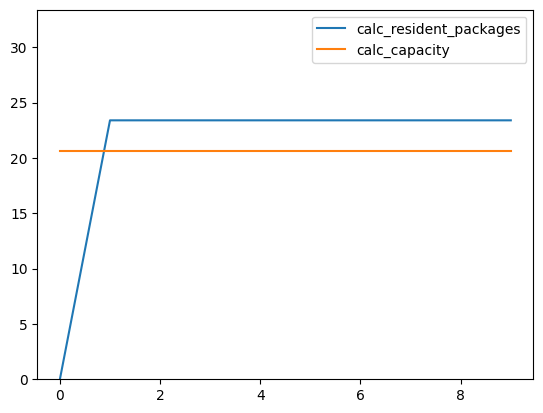

In [ ]:
"""
==To-Do==

* Differentiate contracting fucntion from randomly approaching 
   a microprovider
        ** adding in other ways of approaching micro-providers

* incorporating resident movement
    - how do resident's move around their enviornment
    - should they move randomly?

* rounding problem - you know what it is...
    
==Adding more detail into how micro-provider quality is generated
    how can micro-provider quality increase over time?

==Adding in more detail around how interventions might make a difference to
  micros

==Adding in how microproviders can leave the model, how unpaid carers can leave
  the model

** STARTED adding in quality of care received

** STARTED adding in a quality threshold in order for a micro-provider to provide
care

** STARTED adding in unpaid care agents
    - DONE unpaid carer gives care to resident
    - DONE unpaid carer has care capacity
    - DONE unpaid carer is assigned to resident
        - DONE can they be assigned to multiple residents?
            - DONE yes as long as they have capacity
    - DONE unpaid carer can show an interest in the microproviders their 
      residents use
        - DONE can share this knowledge of unpaid carers with other agents

** STARTED adding in model measures.

* Consider how this will be packaged in a dashboard for people to try.
    - streamlit

THOUGHTS:    

Inevitably out in the community residents needs will become too complex to be
safely delivered by a micro-provider.

Micros will deliver care when they really should be, sometimes...

Micros will recognise when they need to stop delivering care...

Council will intervene with package of care or homecare...
"""

class Resident_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.unpaidcarers = []
        self.unpaidcare_rec = []
        self.microproviders = []
        self.packages_of_care_rec = []
        self.microproviders_to_recommend = []
        self.blacklisted_microproviders = []
        # self.microproviders_to_try = []
        self.care_needs_met = False
        self.care_needs = 0
        self.micro_quality_threshold = 0
        self.initiate_care_needs()
        self.initiate_micro_quality_threshold()
        
    def initiate_care_needs(self):
        self.generate_care_needs = round(random.uniform(10,20),1)
        self.care_needs = self.generate_care_needs

    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual_thrshld = round(random.uniform(0,1),3)
        self.micro_quality_threshold = self.generate_mic_qual_thrshld
    
    def decide_needs_met(self):
        concat_list = self.packages_of_care_rec + self.unpaidcare_rec
        if self.care_needs <= sum(concat_list):
            self.care_needs_met = True
        else:
            self.care_needs_met = False

    def contract_microprovider(self):
        # selecting a microprovider at random
    
        # ADDING OTHERWAYS MICROS CAN BE CONTRACTED ##

        allocated_microprovider_id = random.choice(
            list(model.microprovider_agent_registry.keys())
            )
        
        allocated_microprovider_object = model.microprovider_agent_registry\
            [allocated_microprovider_id]\
            ['agent_object']
        
        #actual process of contracting microprovider
        if allocated_microprovider_id not in self.blacklisted_microproviders and\
            allocated_microprovider_object.micro_quality >=\
            self.micro_quality_threshold: 
            if allocated_microprovider_object.has_capacity:
            # make sure the microprovider is not already contracted--at at any
            # given time we're assuming that a microprovider is only contracted
            # once!
                if allocated_microprovider_id not in self.microproviders:
                    # how much capacity will this micro-provider give?
                    care_delivered = round(
                        random.uniform(
                            1,
                            model.microprovider_agent_registry\
                            [allocated_microprovider_id]\
                            ['agent_care_capacity']),
                        1)
                    #append selected microprovider to residents list of micros
                    self.microproviders.append\
                        (allocated_microprovider_object.unique_id)
                    #append package of care to packages of care received
                    self.packages_of_care_rec.append\
                        (care_delivered)
                    #append resident to microproviders list of residents
                    allocated_microprovider_object.residents.append\
                        (self.unique_id)
                    #append resident's package of care to microproviders packages of care
                    allocated_microprovider_object.packages_of_care.append\
                        (care_delivered)             
                    #update residents care needs met
                    self.decide_needs_met()
                    #update microproviders care capacity going forward
                    allocated_microprovider_object.decide_capacity()
                
    def review_care_received(self):
        last_reviewed_index = None
        # access micros and packages of care they supply
        for index, micro in enumerate(self.microproviders):
            # decide if you want to review the package of care
            review_micro = random.choice([True, False])
            # print(f"review micro = {review_micro}")
            # deciding to review package of care
            if review_micro:
                last_reviewed_index = index
                micro_object = model.microprovider_agent_registry[micro]\
                ['agent_object']
                # review outcome positive
                if self.micro_quality_threshold <= micro_object.micro_quality:
                    # print(
                    #     f"resi {self.unique_id} is happy with the care that "
                    #     f"{micro_object.unique_id} is giving"
                    #     )
                    promote_micro = random.choice([True, False])
                    # choosing to promote microprovider when next chat to residents
                    if promote_micro and\
                    micro not in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.append(micro)
                        # print(
                        #     f"resident {self.unique_id} has added microprovider "
                        #     f"{micro} to their list of microproviders they would "
                        #      "recommend"
                        # )
                    # choosing not to promote micro but happy with care
                    if not promote_micro:
                        pass
                # not happy with package of care and deciding to remove micro
                if not self.micro_quality_threshold + 0.2\
                    <= micro_object.micro_quality:
                    # print(
                    #     f"resident {self.unique_id} is not happy with the care "
                    #     f"they are receiving from microprovider {micro}"
                    # )
                    # blacklisting microprovider so a resident won't contract
                    # them again
                    self.blacklisted_microproviders.append(micro)
                    # removing package of care from package of care received
                    pckg_t_rmv = self.packages_of_care_rec[index]
                    self.packages_of_care_rec.remove(pckg_t_rmv)
                    # print(
                    #     f"resident {self.unique_id} removed micro {micro} "
                    #     f"and their package of care {pckg_t_rmv}"
                    # )
                    # removing microprovider from list and recommendation list
                    # if unhappy
                    self.microproviders.remove(micro)
                    if micro in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.remove(micro)

                    #removing resident from microproviders records also
                    
                    # before removing them, find where the resident is in the
                    # micros packages of care.
                    resi_index = micro_object.residents.index(self.unique_id)
                    resi_package = micro_object.packages_of_care[resi_index]
                    print(
                        f"resident {self.unique_id} is position {resi_index} "
                        f"in the micros package of care list, and they give "
                        f"{resi_package} care"
                    )
                    
                    print(
                        f"resident {self.unique_id} instructes micro "
                        f"{micro_object.unique_id} to remove them"
                    )

                    micro_object.residents.remove(self.unique_id)
                    micro_object.packages_of_care.remove(resi_package)

                    print(
                        f"micro {micro_object.unique_id} revised packages of care " 
                        f"are {micro_object.packages_of_care}"
                    )

            if not review_micro:
                pass

    def promote_microprovider(self):
        nearby_residents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for inhabitant in cellmates:
            if isinstance(inhabitant, Resident_Agent):
                nearby_residents.append(inhabitant)
        
        resident_to_chat = random.choice(nearby_residents)
        # print(resident_to_chat.microproviders_to_recommend)

        for micro in self.microproviders_to_recommend:
            if micro not in resident_to_chat.microproviders_to_recommend and\
            micro not in resident_to_chat.blacklisted_microproviders:
                resident_to_chat.microproviders_to_recommend.append(micro)
                # print(
                #     f"resident {resident_to_chat.unique_id} added micro {micro} "
                #     f"to their list on reccomendation from resident {self.unique_id}" 
                # )
                
    def step(self):
            self.decide_needs_met()
            if self.care_needs_met == False: 
                self.contract_microprovider()
            else:
                pass
            
            self.review_care_received()

            self.promote_microprovider()
    
class MicroProvider_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.packages_of_care = []
        self.has_capacity = True
        self.care_capacity = 0
        self.micro_quality = 0
        self.initiate_care_capacity()
        self.initiate_micro_quality_threshold()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual = round(random.uniform(0,1),3)
        self.micro_quality = self.generate_mic_qual

    def decide_capacity(self):
        if sum(self.packages_of_care) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def step(self):
        self.decide_capacity()

class UnpaidCare_Agent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.unpaidcare_delivered = []
        self.microproviders_to_recommend = []
        self.blacklisted_microproviders = []
        self.has_capacity = True
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def decide_capacity(self):
        if sum(self.unpaidcare_delivered) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def locate_resident(self):
        allocated_resident_id = random.choice(
            list(model.resident_agent_registry.keys())
            )
        
        allocated_resident_object = model.resident_agent_registry\
            [allocated_resident_id]\
            ['agent_object']

        if self.has_capacity and\
            self.unique_id not in allocated_resident_object.unpaidcarers:

                care_delivered = round(
                    random.uniform(1, self.care_capacity),
                    1
                )
                #append selected microprovider to residents list of micros
                self.residents.append\
                    (allocated_resident_object.unique_id)
                #append package of care to packages of care received
                self.unpaidcare_delivered.append\
                    (care_delivered)
                #append resident to microproviders list of residents
                allocated_resident_object.unpaidcarers.append\
                    (self.unique_id)
                #append resident's package of care to microproviders packages of care
                allocated_resident_object.unpaidcare_rec.append\
                    (care_delivered)             
                #update residents care needs met
                allocated_resident_object.decide_needs_met()
                #update microproviders care capacity going forward
                self.decide_capacity()            
        
    def fetch_microproviders(self):
        if len(self.residents) > 0:
            for resident_id in self.residents:
                resident_object = self.model.resident_agent_registry\
                    [resident_id]['agent_object']
                
                # Get the microproviders this resident recommends
                resident_recommended_microproviders = resident_object\
                    .microproviders_to_recommend
                
                # Add recommended microproviders to unpaid carer's list
                # if not already there
                for micro_id in resident_recommended_microproviders:
                    if micro_id not in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.append(micro_id)

    def promote_microprovider(self):
        nearby_residents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for inhabitant in cellmates:
            if isinstance(inhabitant, Resident_Agent) or\
            isinstance(inhabitant, UnpaidCare_Agent):
                 nearby_residents.append(inhabitant)
        
        if nearby_residents:
            resident_to_chat = random.choice(nearby_residents)
            # print(resident_to_chat)

            if self.microproviders_to_recommend:
                for micro in self.microproviders_to_recommend:
                    if micro not in resident_to_chat.microproviders_to_recommend and\
                        micro not in resident_to_chat.blacklisted_microproviders:
                        resident_to_chat.microproviders_to_recommend.append(micro)
                        # print(
                        #     f"agent {resident_to_chat.unique_id} added micro {micro} "
                        #     f"to their list of reccomendations from agent {self.unique_id}" 
                        # )
    
    def step(self):
        if self.has_capacity:
            self.locate_resident()
        self.fetch_microproviders()
        self.promote_microprovider()

class Care_Model(Model):
    # constructor
    def __init__(self,
                N_RESIDENT_AGENTS,
                N_MICROPROVIDER_AGENTS,
                N_UNPAIDCARE_AGENTS,
                width,
                height
                ):
        super().__init__()

        # models own variables
        self.num_resident_agents = N_RESIDENT_AGENTS
        self.num_microprovider_agents = N_MICROPROVIDER_AGENTS
        self.num_unpaidcare_agents = N_UNPAIDCARE_AGENTS
        self.running = True
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # agent registries
        self.resident_agent_registry = {}
        self.microprovider_agent_registry = {}
        self.unpaidcarer_agent_registry = {}

        # adding resident agents
        for i in range(self.num_resident_agents):
            a = Resident_Agent(i, self)
            self.schedule.add(a)
            self.resident_agent_registry[i] = {
                'agent_object' : a,
                'agent_id': i,
                'agent_care_needs': a.generate_care_needs,
                'micro_quality_threshold': a.generate_mic_qual_thrshld,
                'care_needs_met': None,
                'allocated_microproviders': None,
                'packages_of_care_received': None,
                'blacklisted_microproviders': None,
                'microproviders_to_recommend': None,
                'unpaidcarers': None,
                'unpaidcare_rec': None
            }
           
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
            # print(f'placed resident agent {a.pos}')

        # adding micro-provider agents
        for i in range(self.num_microprovider_agents):
            a = MicroProvider_Agent(i, self)
            self.schedule.add(a)
            self.microprovider_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity' : a.generate_care_capacity,
                'micro_quality': a.generate_mic_qual,
                'has_capacity': None,
                'allocated_residents': None,
                'packages_of_care_delivered': None
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
         
        for i in range(self.num_unpaidcare_agents):
            a = UnpaidCare_Agent(i, self)
            self.schedule.add(a)
            self.unpaidcarer_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity': a.generate_care_capacity,
                'has_capacity': a.has_capacity,
                'residents': None,
                'unpaidcare_delivered': None,
                'microproviders_to_recommend': None
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))

        # adding datacollector to model
        self.datacollector = DataCollector(
            model_reporters={
                "calc_allocated_residents":
                  self.calc_allocated_residents,
                "calc_resident_packages":
                  self.calc_packages_of_care_delivered,
                "calc_capacity":
                  self.calc_micro_capacity,
                "has_capacity":
                  self.micro_has_capacity,
                "calc_blacklisted_microproviders":
                  self.calc_blacklisted_microproviders,
                "calc_unpaidcare_received": 
                 self.calc_unpaidcare_received,
                "calc_care_received":
                 self.calc_care_received,
                "calc_care_needs":
                 self.calc_care_needs
            }
        )

    #microprovider functions
    def calc_allocated_residents(self):
        allocated_residents_total = []
        for x in range(len(model.microprovider_agent_registry)):
            allocated_residents = model.microprovider_agent_registry[x]\
                ['allocated_residents']
            if allocated_residents != None:
                allocated_residents_total.extend(allocated_residents)
            else:
                pass 
        return len(allocated_residents_total)

    def calc_packages_of_care_delivered(self):
        packages_of_care_total = []
        for x in range(len(model.microprovider_agent_registry)):
            packages_of_care = model.microprovider_agent_registry[x]\
                ['packages_of_care_delivered']
            if packages_of_care != None:
                packages_of_care_total.extend(packages_of_care)
            else:
                pass
        return sum(packages_of_care_total)
    
    def calc_micro_capacity(self):
        total_care_capacity = []
        for x in range(len(model.microprovider_agent_registry)):
            care_capacity = (model.microprovider_agent_registry[x]\
                ['agent_care_capacity'])
            total_care_capacity.append(care_capacity)
        return sum(total_care_capacity)

    def micro_has_capacity(self):
        has_capacity = []
        for x in range(len(model.microprovider_agent_registry)):
            microprovider_has_capacity = model.microprovider_agent_registry[x]\
                ['has_capacity']

            if microprovider_has_capacity == False:
                has_capacity.append(microprovider_has_capacity)
        return len(has_capacity)

    #resident functions
    
    def calc_blacklisted_microproviders(self):
        total_blacklisted_microproviders = []
        for x in range(len(model.resident_agent_registry)):
            blacklisted_microproviders = model.resident_agent_registry[x]\
                ['blacklisted_microproviders']
            if blacklisted_microproviders != None:
                total_blacklisted_microproviders.extend\
                    (blacklisted_microproviders)
            else:
                pass
        return len(total_blacklisted_microproviders)

    def calc_unpaidcare_received(self):
        total_unpaidcare_delivered = []
        for x in range(len(model.resident_agent_registry)):
            unpaidcare_delivered =model.resident_agent_registry[x]\
                ['unpaidcare_rec']
            if unpaidcare_delivered != None:
                total_unpaidcare_delivered.extend(model.resident_agent_registry[x]\
                ['unpaidcare_rec'])
        return sum(total_unpaidcare_delivered)

    # should this also include unpaid care??
    def calc_care_received(self):
        total_care_received = []
        for x in range(len(model.resident_agent_registry)):
            care_received = model.resident_agent_registry[x]\
            ['packages_of_care_received']
            # print(care_received)
            if care_received != None:
                total_care_received.extend(care_received)
        return sum(total_care_received)

    def calc_care_needs(self):
        total_care_needs = []
        for x in range(len(model.resident_agent_registry)):
            care_needs = (model.resident_agent_registry[x]\
            ['agent_care_needs'])
            total_care_needs.append(care_needs)
        return sum(total_care_needs)

    # what happens in each step of the model
    def step(self):

        #first, collect data
        self.datacollector.collect(self)

        # what happens in each step for each type of Agent
        for agent in self.schedule.agents:    
            # micro-provider agents
            if isinstance(agent, MicroProvider_Agent):
                self.microprovider_agent_registry[agent.unique_id]\
                    ['allocated_residents'] = agent.residents
                self.microprovider_agent_registry[agent.unique_id]\
                    ['packages_of_care_delivered'] = agent.packages_of_care
                self.microprovider_agent_registry[agent.unique_id]\
                    ['has_capacity'] = agent.has_capacity

            if isinstance(agent, Resident_Agent):
                self.resident_agent_registry[agent.unique_id]\
                    ['allocated_microproviders'] = agent.microproviders
                self.resident_agent_registry[agent.unique_id]\
                    ['packages_of_care_received'] = agent.packages_of_care_rec
                self.resident_agent_registry[agent.unique_id]\
                    ['care_needs_met'] = agent.care_needs_met
                self.resident_agent_registry[agent.unique_id]\
                    ['blacklisted_microproviders']\
                    = agent.blacklisted_microproviders
                self.resident_agent_registry[agent.unique_id]\
                    ['microproviders_to_recommend']\
                    = agent.microproviders_to_recommend
                self.resident_agent_registry[agent.unique_id]\
                    ['unpaidcarers'] = agent.unpaidcarers
                self.resident_agent_registry[agent.unique_id]\
                    ['unpaidcare_rec'] = agent.unpaidcare_rec
                
            if isinstance(agent, UnpaidCare_Agent):
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['residents'] = agent.residents
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['unpaidcare_delivered'] = agent.unpaidcare_delivered
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['has_capacity'] = agent.has_capacity
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['microproviders_to_recommend'] =\
                    agent.microproviders_to_recommend

            # after configuring unique behaviours, each agent steps
            agent.step()
        
        # add next step to schedule        
        self.schedule.step()

#Set the parameters for your model
N_RESIDENT_AGENTS = 10
N_MICROPROVIDER_AGENTS = 3
N_UNPAIDCARE_AGENTS = 1
width = 20
height = 20

model = Care_Model(
    N_RESIDENT_AGENTS,
    N_MICROPROVIDER_AGENTS,
    N_UNPAIDCARE_AGENTS,
    width, 
    height)

# Run the model for a certain number of steps
num_steps = 10
for i in range(num_steps):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

#print(data)

#copy and paste outputs and just put in sublime text for easy read
print(f'resident agent register {model.resident_agent_registry}')
print(f'micro-provider register {model.microprovider_agent_registry}') 
print(f'unpaid care register {model.unpaidcarer_agent_registry}') 

data

fig,ax = plt.subplots()
ax.set_ylim(ymin=0, ymax=data['calc_resident_packages'].max()+10)
data.plot(kind='line', y='calc_resident_packages', ax=ax)
data.plot(kind='line', y='calc_capacity', ax=ax)

In [ ]:


# print(data[0]['allocated_residents'])
allocated_residents = data[0]['allocated_residents']

def calc_allocated_residents():
    allocated_residents_total = []
    for x in range(len(data)):
        allocated_residents = data[x]['allocated_residents']
        allocated_residents_total.extend(allocated_residents) 
    return allocated_residents_total

def calc_resident_packages():
    packages_of_care_total = []
    for x in range(len(data)):
        packages_of_care = data[x]['packages_of_care_delivered']
        packages_of_care_total.extend(packages_of_care)
        # rint(allocated_residents_total)  
    return sum(packages_of_care_total)

def calc_capacity():
    care_capacity = []
    for x in range(len(data)):
        care_capacity.append(data[x]['agent_care_capacity'])
    return sum(care_capacity)

def has_capacity():
    has_capacity = []
    for x in range(len(data)):
        has_capacity.append(data[x]['has_capacity'])
    return has_capacity

# calc_allocated_residents()
# calc_resident_packages()
# calc_capacity()
# has_capacity()

def calc_blacklisted_microproviders():
    blacklisted_microproviders = []
    for x in range(len(data2)):
        blacklisted_microproviders.extend(data2[x]['blacklisted_microproviders'])
    return blacklisted_microproviders

def calc_unpaidcare_received():
    unpaidcare_delivered = []
    for x in range(len(data2)):
        unpaidcare_delivered.extend(data2[x]['unpaidcare_rec'])
    return sum(unpaidcare_delivered)

def calc_care_received():
    care_received = []
    for x in range(len(data2)):
        care_received.extend(data2[x]['packages_of_care_received'])
    return sum(care_received)

def calc_care_needs():
    total_care_needs = []
    for x in range(len(data2)):
        total_care_needs.append(data2[x]['agent_care_needs'])
    return sum(total_care_needs)

# calc_blacklisted_microproviders()
# calc_unpaidcare()
# calc_care_needs()
# round(calc_care_received(),1)

